# AN2L Challenge: Homework 1
**Gruppo**: cars

**Membri**: Riccardo Storchi, Anna De Simone, Caterina Giardi, Sophie Barbera.

In [ ]:
# For installing keras-cv
#!pip install keras-cv tensorflow --upgrade

## Library & Drive

In [ ]:

# Fix randomness and hide warnings
seed = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
import keras_cv
import keras_core as keras
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import Sequential
from tensorflow.data import Dataset

#aggiunto, non presente in challenge6
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

#from torchvision.utils import save_image
# tf.compat.v1.disable_eager_execution()

# Import other libraries
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.layers import Dense, Dropout, Average, Input
from tensorflow.keras.models import Model

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend
2.13.0
Found GPU at: /device:GPU:0


## Process data

In [ ]:
#----------LOAD DATA------------------------------------------------------------

dataset = np.load('/kaggle/input/pianteq/public_data.npz', allow_pickle=True)
lst = dataset.files
print(type(dataset))


X = dataset['data']

#for i in range(X.shape[0]):
#  X[i] = (X[i] / 255).astype(np.float32)

labels = dataset['labels']

y = [1 if i == "unhealthy" else 0 for i in labels ]
y = np.array(y)
print(X.shape)
print(y.shape)

#----------DATA CLEANING--------------------------------------------------------
#clutter
shrek = X[58]
#print(y[58])
trololo = X[338]
#print(y[338])


columns = []

for i in range (X.shape[0]):
  difference1 = cv2.subtract(X[i], shrek)
  difference2 = cv2.subtract(X[i], trololo)
  result = not (np.any(difference1) and np.any(difference2))
  if result is True:
      columns.append(i)

X = np.delete(X, (columns), axis=0)
y = np.delete(y, (columns), axis=0)
print("After decluttering:")
print(X.shape)
print(y.shape)


input_shape = X[0].shape
output_shape = 1



l=[]
images, indexes, count = np.unique(X, return_index=True, return_inverse=False, return_counts=True, axis=0)
for i in range(images.shape[0]):
  l.append(y[indexes[i]])
print('sorting shapes')
print(len(l))
print(images.shape)



X = np.array(images)
y = np.array(l)
print(y.shape)
print(X.shape)

l, counts = np.unique(y, return_counts=True)
print(l, counts)



<class 'numpy.lib.npyio.NpzFile'>
(5200, 96, 96, 3)
(5200,)
After decluttering:
(5004, 96, 96, 3)
(5004,)
sorting shapes
4850
(4850, 96, 96, 3)
(4850,)
(4850, 96, 96, 3)
[0 1] [3060 1790]


## Data Splitting

In [ ]:
#---------DATA SPLITTING--------------------------------------------------------


#X = X/255

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.10, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)

y_train = np.array(y_train)
y_val = np.array(y_val)
# y_test = np.array(y_test)
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
# print(np.unique(y_test, return_counts=True))

# Fixing y
y_train_B = np.array([[0,1] if label==1 else [1,0] for label in y_train])
# y_test_B = np.array([[0,1] if label==1 else [1,0] for label in y_test])
y_val_B = np.array([[0,1] if label==1 else [1,0] for label in y_val])
y_B = np.array([[0,1] if label==1 else [1,0] for label in y])


X_train shape: (4365, 96, 96, 3), y_train shape: (4365,)
X_val shape: (485, 96, 96, 3), y_val shape: (485,)
(array([0, 1]), array([2754, 1611]))
(array([0, 1]), array([306, 179]))


# Augmentation

## Augmenter

In [ ]:
augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.GridMask(),
        keras_cv.layers.RandAugment(value_range=(0, 255)),
        keras_cv.layers.CutMix(),
    ],
)

def preprocess_data(images, labels, augment=False):
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']

train_dataset = Dataset.from_tensor_slices((X_train, y_train_B))
val_dataset = Dataset.from_tensor_slices((X_val, y_val_B))

train_dataset = train_dataset.batch(32).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).map(
    preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
        tf.data.AUTOTUNE)

# Model Experiment

## MobileNetV2

In [ ]:
data_augmentation = models.Sequential([
      tfkl.RandomTranslation(0.2,0.2),
      tfkl.RandomRotation(0.2),
      tfkl.RandomZoom(0.2),
])

input_shape =  X_train[0].shape
cnn = tfk.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg'
    )
cnn.trainable = False
print(cnn.name)
print(input_shape)

from tensorflow.keras.applications.mobilenet import preprocess_input
inputs = tfk.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = cnn(x)
tfkl.Flatten(), # tfkl.GlobalAveragePooling2D(),
outputs = tfkl.Dense(2, activation='softmax')(x)

mobile_model = tfk.Model(inputs=inputs, outputs=outputs)
mobile_model.compile(optimizer=AdamW(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
]

mobile_model.fit(train_dataset, epochs=100, callbacks=callbacks, validation_data=val_dataset)
mobile_model.save('SimpleMobileV3NetLarge_1')

In [ ]:
mobile_model = tfk.models.load_model('SimpleMobileV3NetLarge_1')
mobile_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
mobile_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(mobile_model.get_layer('mobilenetv2_1.00_96').layers):
  if layer._class_._name_ == 'BatchNormalization' or layer._class_._name_ == 'LayerNormalization' :
    layer.trainable = False
  print(i, layer.name, layer.trainable)
# i = numero layers. ne tolgo un po alla volta, metto fino a N false e resto true per fine tuning successivo

mobile_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
]

In [ ]:
mobile_model.fit(train_dataset, epochs=100, callbacks=callbacks,  validation_data=val_dataset)
mobile_model = tfk.models.load_model('SimpleMobileV3NetLarge_2')

# Final models

## EfficientNetV2M

In [ ]:
#data augmentation
data_augmentation = models.Sequential([
      tfkl.RandomTranslation(0.2,0.2),
      tfkl.RandomRotation(0.2),
      tfkl.RandomZoom(0.2)
])

input_shape =  X_train[0].shape
cnn = tfk.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    include_preprocessing=True,
    )
cnn.trainable = False



#model
eff_M_model = models.Sequential([
      tfk.Input(shape=input_shape),
      data_augmentation,
      cnn,
      tfkl.GlobalAveragePooling2D(),
      tfkl.Dense(2, activation='softmax')
    ])

eff_M_model.compile(optimizer=AdamW(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
]

eff_M_model.fit(train_dataset, epochs=200, callbacks=callbacks, validation_data=val_dataset)
eff_M_model.save('ModelloEfficientnetLVanilla_1')

In [ ]:
eff_M_model = tfk.models.load_model('ModelloEfficientnetMVanilla_1')
eff_M_model.summary()

In [ ]:
eff_M_model.get_layer('efficientnetv2-m').trainable = True
for i, layer in enumerate(eff_M_model.get_layer('efficientnetv2-m').layers):
  if layer.__class__.__name__ == 'BatchNormalization' or layer.__class__.__name__ == 'LayerNormalization' :
    layer.trainable = False
  print(i, layer.name, layer.trainable)
eff_M_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(1e-5), metrics='accuracy')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
]

In [ ]:
eff_M_model.fit(train_dataset, epochs=100, callbacks=callbacks,  validation_data=val_dataset)
eff_M_model = tfk.models.load_model('ModelloEfficientnetLVanilla_2')

## ConvNeXtLarge Gap

In [ ]:
input_shape =  X_train[0].shape

# data augmentation
data_augmentation = models.Sequential([
      tfkl.RandomTranslation(0.2,0.2),
      tfkl.RandomRotation(0.2),
      tfkl.RandomZoom(0.2)
])

cnn = tfk.applications.ConvNeXtLarge(
    include_top=False,
    weights="imagenet",
    #input_shape=input_shape,
    include_preprocessing=True,
    )
cnn.trainable = False


simple_convL = models.Sequential([
      tfk.Input(shape=input_shape),
      data_augmentation,
      cnn,
      tfkl.GlobalAveragePooling2D(),
      #tfkl.Dropout(0.2),
      tfkl.Dense(2, activation='softmax')
    ])

simple_convL.compile(optimizer=AdamW(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
]

simple_convL.fit(train_dataset, epochs=100, callbacks=callbacks, validation_data=val_dataset)
simple_convL.save('SimpleConvNeXtLarge_1')

In [ ]:
ft_model = tfk.models.load_model('SimpleConvNeXtLarge_1')
ft_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
  if layer.__class__.__name__ == 'BatchNormalization' or layer.__class__.__name__ == 'LayerNormalization' :
    layer.trainable = False
  print(i, layer.name, layer.trainable)

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
ft_model.fit(train_dataset, epochs=100, callbacks=callbacks,  validation_data=val_dataset)
ft_model = tfk.models.load_model('SimpleConvNeXtLarge_2')

# Ensembling

In [ ]:
from tensorflow.keras.layers import Average


# retrive the models

class LayerScale(tfkl.Layer):

    def _init_(self, init_values: float, projection_dim: int, **kwargs):
        super()._init_(**kwargs)
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma

model1 = tf.keras.models.load_model("/kaggle/input/convex-cat/model", custom_objects={'LayerScale': LayerScale})


class LayerScale(tfkl.Layer):

    def _init_(self, init_values: float, projection_dim: int, **kwargs):
        super()._init_(**kwargs)
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma

model2 = tf.keras.models.load_model("/kaggle/input/efficientnetl/efficient_L", custom_objects={'LayerScale': LayerScale})



In [ ]:
# print the summary of the models
model1.summary()
model2.summary()

models = [model1, model2]

input_layer = Input(shape=(96, 96, 3), name='input')

outputs = [model(input_layer) for model in models]

# Average of the outputs
x = Average()(outputs)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax', name='output')(x)

# Average ensembled model
avg_model = Model(inputs=input_layer, outputs=output)

# I put the trainable status False for the models that are already trained (input)
for model in models:
    model.trainable = False

avg_model.summary()

avg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = avg_model.fit(train_dataset, epochs=200, callbacks=[EarlyStopping(monitor='val_loss', patience=20)], validation_data=val_dataset).history


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, None, None, 1536   196230336 
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 196233410 (748.57 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 196233410 (748.57 MB)
_________________________________________________________________
Model: "

2023-11-18 18:18:26.578381: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/sequential_13/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


137/137 [==============================] - 89s 352ms/step - loss: 0.5587 - accuracy: 0.7530 - val_loss: 0.2936 - val_accuracy: 0.9258
Epoch 2/200
137/137 [==============================] - 40s 287ms/step - loss: 0.4556 - accuracy: 0.8243 - val_loss: 0.2271 - val_accuracy: 0.9278
Epoch 3/200
137/137 [==============================] - 40s 290ms/step - loss: 0.4519 - accuracy: 0.8231 - val_loss: 0.2178 - val_accuracy: 0.9278
Epoch 4/200
137/137 [==============================] - 40s 291ms/step - loss: 0.4400 - accuracy: 0.8344 - val_loss: 0.2148 - val_accuracy: 0.9299
Epoch 5/200
137/137 [==============================] - 40s 292ms/step - loss: 0.4357 - accuracy: 0.8344 - val_loss: 0.2141 - val_accuracy: 0.9299
Epoch 6/200
137/137 [==============================] - 41s 293ms/step - loss: 0.4432 - accuracy: 0.8284 - val_loss: 0.2160 - val_accuracy: 0.9299
Epoch 7/200
137/137 [==============================] - 41s 294ms/step - loss: 0.4410 - accuracy: 0.8302 - val_loss: 0.2160 - val_accurac

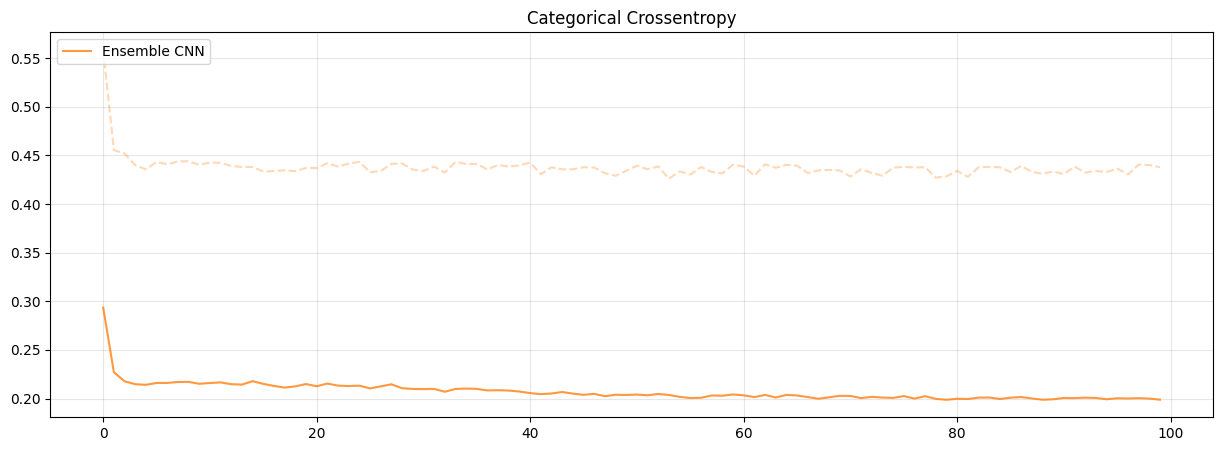

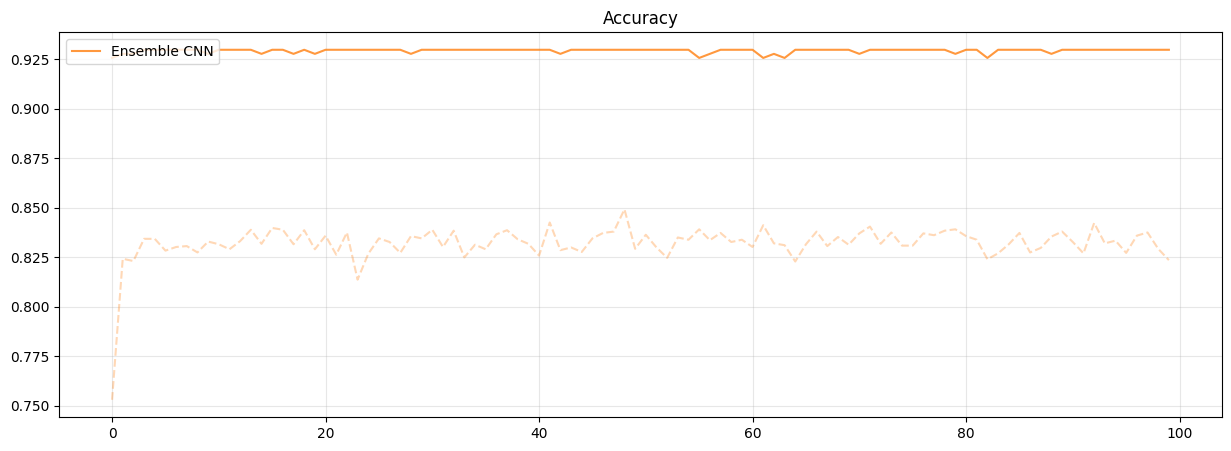

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Ensemble CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Ensemble CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
avg_model.save('EnsembleCE128')

In [ ]:
!zip -r file.zip /kaggle/working
!ls
from IPython.display import FileLink
FileLink(r'file.zip')